# Skyplane API

Users are starting to compose Skyplane into larger applications! Data transfer across the cloud is often a critical component of most project pipelines, and Skyplane's simplicity and efficiency is an attractive tool for developers to handle this stage of the process. For easy and fast integration, Skyplane offers an API which enables users the same functionality as the CLI (e.g. copy, sync, etc.) along with some API-specific features. This has exciting implications for the growth of Skyplane and applications leveraging it going forward.

Examples of use cases include but are not limited to: 
1. ML training, You will hear about Skypilot; 
2. Persistent synchronization, You can have incremental syncs to enable disaster recovery for apps running in other clouds; 
3. Skyplane Storage, Building storage API on top of the current API.

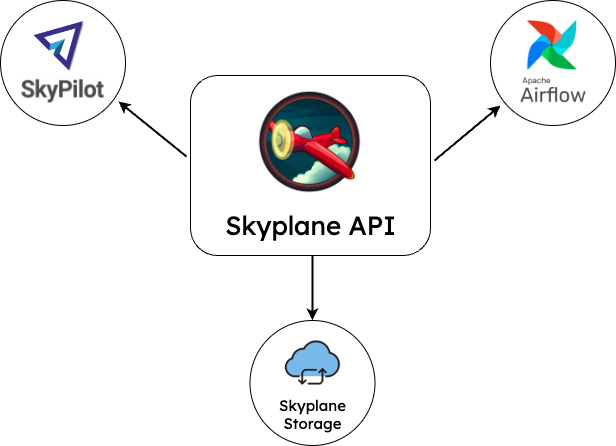

## Overview

In [1]:
from skyplane.api.api_class import *

### Simple Copy

In [2]:
client = SkyplaneClient()
client.copy(src="s3://jason-us-east-1/fake_imagenet/", dst="s3://jason-us-west-2/fake_imagenet_1/", 
                   recursive=True)

### Sessions

In [ ]:
session = client.new_session(
    src_bucket="aws:jason-us-east-1", 
    dst_bucket="aws:jason-us-west-2", 
    num_vms=1, 
    solver=None # Skypane DirectSolver
)

with session as s:
    session.auto_terminate()
    s.copy("fake_imagenet", "fake_imagenet_test", recursive=True)
    s.copy("fake_imagenet", "fake_imagenet_rand", recursive=True)
    # This will start the transfer in separate process
    future1 = s.run_async()
    s.copy("fake_imagenet", "fake_imagenet_2", recursive=True)
    # This will start the transfer in separate process
    future2 = s.run_async()
    # This waits the transfer until complete
    s.wait_for_completion(future2)
    s.wait_for_completion(future1)

## ML Training Leveraging Skyplane Data Transfer

In [3]:
import argparse
import os
import random
import shutil
import time
import warnings

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.multiprocessing as mp
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
from torch.utils.data import IterableDataset, DataLoader
from awsio.python.lib.io.s3.s3dataset import S3IterableDataset

import torchvision.models as models
from PIL import Image
import io
from itertools import islice

In [4]:
class ImageNetS3(IterableDataset):
    def __init__(self, url_list, shuffle_urls=False, transform=None):
        self.s3_iter_dataset = S3IterableDataset(url_list,
                                                 shuffle_urls)
        self.transform = transform


    def data_generator(self):
        try:
            while True:
                # Based on aplhabetical order of files sequence of label and image will change.
                # e.g. for files 0186304.cls 0186304.jpg, 0186304.cls will be fetched first
                label_fname, label_fobj = next(self.s3_iter_dataset_iterator)
                image_fname, image_fobj = next(self.s3_iter_dataset_iterator)
                label = int(label_fobj)
                image_np = Image.open(io.BytesIO(image_fobj)).convert('RGB')

                # Apply torch visioin transforms if provided
                if self.transform is not None:
                    image_np = self.transform(image_np)
                yield image_np, label

        except StopIteration:
            return

    def __iter__(self):
        self.s3_iter_dataset_iterator = iter(self.s3_iter_dataset)
        return self.data_generator()

In [5]:
def train(train_loader, model, criterion, optimizer, epoch):
    # switch to train mode
    model.train()

    for i, (images, target) in enumerate(train_loader):
        # compute output
        output = model(images)
        loss = criterion(output, target)
        print(f"Current loss for batch#{i} is:")
        print(loss.item())

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [2]:
data_url = ["s3://jason-us-east-1/imagenet-train-000000.tar"]
# Now if we want to transfer our dataset from us-east-1 to us-west-2 
# since our vm is launched there
# We can use Skyplane!!!
client1 = SkyplaneClient()
client1.copy(src="s3://jason-us-east-1/imagenet-train-000000.tar", 
            dst="s3://jason-us-west-2/imagenet-train-000000.tar", recursive=False)
data_url = ["s3://jason-us-west-2/imagenet-train-000000.tar"]

Output()

Will transfer 1 objects totaling 106.36MB from aws:us-east-1 to aws:us-west-2

VMs to provision: 1x aws:us-east-1, 1x aws:us-west-2

Estimated egress cost: $0.00 at $0.02/GB

imagenet-train-000000.tar => imagenet-train-000000.tar

copy: s3://jason-us-east-1/imagenet-train-000000.tar to s3://jason-us-west-2/imagenet-train-000000.tar


In [ ]:
batch_size = 256

# Torchvision transforms to apply on data
preproc = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

dataset = ImageNetS3(data_url, transform=preproc)

train_loader = DataLoader(dataset,
                        batch_size=batch_size,
                        num_workers=2)

model = models.__dict__['resnet18'](pretrained=True)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), 0.1,
                            momentum=0.9,
                            weight_decay=1e-4)

In [ ]:
for epoch in range(5):
    train(train_loader, model, criterion, optimizer, epoch)
    break

In [ ]:
# Finally, we can back up the model to the cloud, by Skyplane
torch.save(model.state_dict(), "./sample_model.pkl")
client1.copy(src="./sample_model.pkl", 
            dst="s3://jason-us-west-2/", recursive=False)

## Integration into Existing Application Pipelines